In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
from VAE1_mix import VAE3
from datasets import load_dataset
import torch.optim as optim
import torch.utils.data
from IPython.display import clear_output
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
# full_data=pd.concat([X2,y], axis=1)
# values_to_match=['ARP_poisioning', 'DDOS_Slowloris', 'DOS_SYN_Hping',
#                  'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN',
#                  'NMAP_OS_DETECTION', 'NMAP_TCP_scan', 'NMAP_UDP_SCAN',
#                  'NMAP_XMAS_TREE_SCAN']
# anomalous_data=full_data[full_data['Attack_type'].isin(values_to_match)]
# anomalous_data=anomalous_data.iloc[:, :-1]
# # anomalous_data
# print(anomalous_data[anomalous_data.notna().any(axis=1)].shape, anomalous_data.shape)
# anomalous_data

In [3]:
dataset = load_dataset("aamui/rt_iot_2022")

In [4]:
df=dataset['train'].to_pandas().filter(regex='^((?!max|min|avg|std).)*$')

df = df.drop(columns = ['id.orig_p', 'id.resp_p']) # drop IDs

# one-hot encode categoricals and standardize numerics
cat_cols = ['proto', 'service']
quant_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers = [
        ('quant', StandardScaler(), quant_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ], 
    remainder = 'passthrough')

df_processed = preprocessor.fit_transform(df)
column_names = quant_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
column_names += df.columns.drop(quant_cols + cat_cols).tolist()
df = pd.DataFrame(df_processed, columns = column_names)

# print('Final preprocessed data shape:', df.shape)

def binary_label_convert(data):
    normal_types = ['Wipro_bulb', 'Thing_Speak', 'MQTT_Publish', 'Alexa']
    data['Binary_label'] = data['Attack_type'].apply(lambda x: 0 if x in normal_types else 1)
    return data

df = binary_label_convert(df)

# performing splits for train, cv, test
normal = df[df['Binary_label'] == 0]
attack = df[df['Binary_label'] == 1]

# normal data: 70% for training and 30% for testing/validation
train_data, temp_normal = train_test_split(normal, test_size = 0.3, random_state = 21, stratify = normal['Attack_type'])
# further split normal data: 15% for cv and 15% for test
validate_normal, test_normal = train_test_split(temp_normal, test_size = 0.5, random_state = 21)
# attack data: 50% for cv, 50% for test
validate_attack, test_attack = train_test_split(attack, test_size = 0.5, random_state = 21)

# combine
cv_data = pd.concat([validate_normal, validate_attack])
test_data = pd.concat([test_normal, test_attack])

# final split variables
X_train = train_data.drop(columns = ['Attack_type', 'Binary_label'])
y_train = pd.DataFrame(train_data['Binary_label'])
type_train = train_data[["Attack_type"]]

X_cv = cv_data.drop(columns = ['Attack_type', 'Binary_label'])
y_cv = pd.DataFrame(cv_data['Binary_label'])
type_cv = cv_data[["Attack_type"]]

X_test = test_data.drop(columns = ['Attack_type', 'Binary_label'])
y_test = pd.DataFrame(test_data['Binary_label'])
type_test = test_data[["Attack_type"]]

# convert to tensors
X_train = X_train.astype('float32')
X_train = torch.tensor(X_train.values, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32)

X_cv = X_cv.astype('float32')
X_cv = torch.tensor(X_cv.values, dtype = torch.float32)
y_cv = torch.tensor(y_cv.values, dtype = torch.float32)

X_test = X_test.astype('float32')
X_test = torch.tensor(X_test.values, dtype = torch.float32)
y_test = torch.tensor(y_test.values, dtype = torch.float32)



In [5]:
# https://arxiv.org/pdf/2006.08204
# def beta_elbow(x_hat, x, beta, N, z_mu, z_sigma):
#     # this loss assumes that all columns are continuous which i believe is true
#     beta_cross_entropy=-((beta+1)/beta) * torch.mean(torch.exp((-0.5 * z_sigma * beta) * torch.sum((x_hat - x)**2))-1)
#     kl_div=torch.mean(0.5 * torch.sum(1 + 2 * torch.log(z_sigma) - (z_mu**2)  - (z_sigma**2), -1))
#     return beta_cross_entropy + kl_div

In [6]:
def plot_loss(loss):
    epoch = len(loss)
    plt.plot(1+np.arange(epoch), loss, marker='o', color='red')
    plt.ylim(bottom=0)
    plt.title('ELBO Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid()

In [7]:
batch_size = 64
cat_feature_idx=[i for i in range(43,56)]
train_dataset = torch.utils.data.TensorDataset(X_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

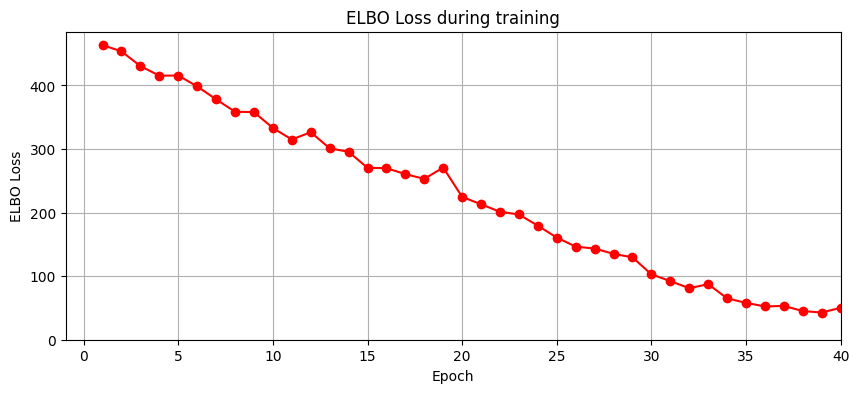

Epoch [40/40], ELBO Loss: 50.2596


In [11]:
vae3=VAE3(z_dim=40, input_dim=X_train.shape[1], h_dim1=400, h_dim2=300)
optimizer=optim.Adam(vae3.parameters(), lr=1e-6)
beta_losses=[]
epochs=40

for epoch in range(epochs):
    vae3.train()
    for data in train_loader:
        data=data[0]
        optimizer.zero_grad()
        recon, mu, sigma=vae3(data)
        loss, _ =vae3.combo_elbo(recon, data, mu, sigma, cat_feature_indicies=cat_feature_idx)
        loss.backward()
        optimizer.step()
    beta_losses.append(loss.item())

    clear_output(wait=True)
    plt.figure(figsize=(10,4))
    plot_loss(beta_losses)
    plt.xlim(right=40)
    plt.show()

    print(f'Epoch [{epoch + 1}/{40}], ELBO Loss: {loss.item():.4f}')
